# Data Augumentation

In questo notebook mostreremo un panoramica sulla data augmentation. L'obbiettivo è aggiungere agli audio del nostro dataset del rumore reale. Per fare ciò abbiamo utilizzato un altro dataset contenente 10 sample di noise.

## Importazione delle librerie

Iniziamo importando le librerie che abbiamo utilizzato per l'analisi e la visualizzazione dei nostri dati.

In [41]:
import tensorflow as tf
import numpy as np
import librosa
import IPython.display as IPD
from IPython.display import Audio
import matplotlib.pyplot as plt
import random
import wave

## Importazione dei dataset
Importiamo tutti i dataset contenenti gli audio necessari. Oltre al train_ds e validation_ds importiamo anche il nostro nuovo dataset contenente gli audio rumorosi.

In [44]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    #directory='../reduced_dataset/dataset/audio',
    directory ='../DL_PROJECT/reduced_dataset/train/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    #directory='../noise_dataset',
    directory='../DL_PROJECT/noise_dataset',
    batch_size = 1
)

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.
Found 10 files belonging to 10 classes.


## Differenza tra rumore e audio 

In [47]:
for n, label in noise_ds:
    print(np.shape(n)) # mostriamo lo shape dei nostri audio rumorosi
    break

(1, 518400, 1)


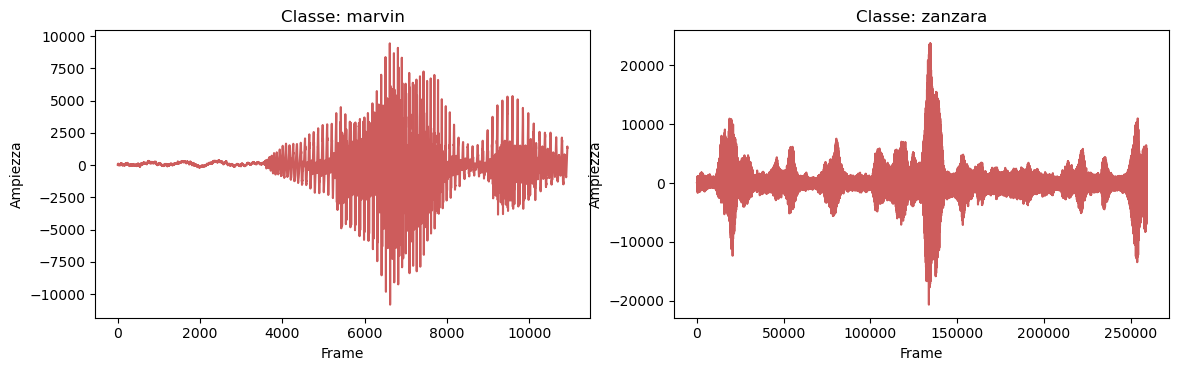

In [146]:
path_audio = '../DL_PROJECT/reduced_dataset/train/audio/marvin/0a9f9af7_nohash_2.wav'
audio = wave.open(path_audio, "r").readframes(-1)
audio = np.frombuffer(audio, dtype=np.int16)

path_audio_noise = '../DL_PROJECT/noise_dataset/class_4/sample-4.wav'
noise = wave.open(path_audio_noise, "r").readframes(-1)
noise = np.frombuffer(noise, dtype=np.int16)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # aumenta la dimensione della figura
fig.tight_layout(pad=3.0)  # aggiungi padding tra i subplot

#Spettogramma audio normale
ax[0].set_title('Classe: marvin')
ax[0].set_ylabel('Ampiezza')
ax[0].set_xlabel('Frame')
ax[0].plot(audio, color="indianred")

#Spettogramma noise
ax[1].set_title('Classe: zanzara')
ax[1].set_ylabel('Ampiezza')
ax[1].set_xlabel('Frame')
ax[1].plot(noise, color="indianred")


plt.show()

Come possiamo notare la lunghezza degli audio rumorosi è molto più lunga rispetto a quella dei nostri audio normali.

## Taglio degli audio rumorosi
Come abbiamo visto in precedenza gli audio rumorosi e gli audio normali hanno lunghezze diverse. Perciò procediamo a tagliare gli audio rumorosi ad una lunghezza di un secondo. 

In [101]:
new_noise_audios = [] # inizializziamo una lista dove inseriremo i nostri noise tagliati

# iteriamo nel dataset con gli audio rumorosi
for noise, label in noise_ds:
    # tagliamo l'audio ad un secondo e lo appendiamo a una lista 
    noise = tf.reshape(noise, [-1])[600:16600]
    new_noise_audios.append(noise.numpy()) # convertiamo in array per poterli modificare
    
test_noise_audio = new_noise_audios[0].astype(np.float32)
print(np.shape(new_noise_audios))

(10, 16000)


In [119]:
print(len(new_noise_audios))

10


In [121]:
for noise in new_noise_audios: # iteriamo la lista contenente i noise tagliati e li ascoltiamo
    display(Audio(noise, rate=16000))

In [164]:
rows = 5
cols = 2

labels = new_noise_audios(noise.keys()) # mi salvo la lista delle label
# Plottiamo tutti i noise
fig, axes = plt.subplots(rows, cols, figsize=(12, 18))  # aumenta la dimensione della figura
fig.tight_layout(pad=3.0)  # aggiungi padding tra i subplot

for index, noise in enumerate(new_noise_audios):
    row = index // cols
    col = index % cols

    ax = axes[row][col]
    
    ax.set_ylabel('Ampiezza', fontweight="bold")
    ax.set_xlabel('# frame', fontweight="bold")
    ax.set_title(str(labels[index]))
    ax.plot(noise, color="indianred")
    
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

## Unione del rumore ai nostri file audio
Ora che abbiamo la nostra lista di audio rumorosi con la lunghezza giusta possiamo procedere alla sovrapposizione del rumore.

In [8]:
mixed_dataset = [] # inizializziamo la lista dove inseriremo gli audio uniti al rumore

counter = 0

train_ds = train_ds.unbatch()
labels_np = np.array([label.numpy() for _, label in train_ds])

for audio, label in train_ds:    
    audio = np.squeeze(audio, axis=-1)
    
    # Scegliamo in modo randomico un audio dalla lista ri
    noise_sample = random.choice(new_noise_audios)

    mixed_audio = audio + noise_sample # mo00ltiplichiamo per un valore costante molto piccoli cosi da ridurre il volume del rumore e far sentire meglio l'audio del comando
        
    # appendiamo alla lista mixed dataset
    mixed_dataset.append((mixed_audio, label))

# trasformiamo la lista mixed_dataset in un dataset da poter passare ai modelli
# mixed_dataset = tf.data.Dataset.from_tensor_slices(mixed_dataset)

In [9]:
print(mixed_dataset[0])

(array([ 0.00061035,  0.00033569, -0.00042725, ...,  0.00146484,
        0.00067139,  0.00021362], dtype=float32), <tf.Tensor: shape=(), dtype=int32, numpy=27>)


In [10]:
audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in mixed_dataset]
labels = [label for _, label in mixed_dataset]

In [11]:
mixed_dataset = tf.data.Dataset.from_tensor_slices((audio_data, labels))

In [12]:
counter = 0

for audio, label in mixed_dataset:
    print(audio)
    print(label)
    display(Audio(audio, rate=16000))

    if counter == 2:
        break

    counter += 1



tf.Tensor(
[ 0.00061035  0.00033569 -0.00042725 ...  0.00146484  0.00067139
  0.00021362], shape=(16000,), dtype=float32)
tf.Tensor(27, shape=(), dtype=int32)


tf.Tensor(
[-0.04086304 -0.02334595 -0.0043335  ... -0.06311035 -0.0604248
 -0.05728149], shape=(16000,), dtype=float32)
tf.Tensor(11, shape=(), dtype=int32)


tf.Tensor(
[-0.05749512 -0.05819702 -0.0579834  ...  0.03720093  0.03918457
  0.03955078], shape=(16000,), dtype=float32)
tf.Tensor(12, shape=(), dtype=int32)
